In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
from diffusers import StableDiffusionPipeline

2025-04-07 17:55:49.220409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744041349.253293 1786703 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744041349.269866 1786703 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-07 17:55:49.291975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Stable Diffusion model pretrained


In [2]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
print(pipe)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Modèle de génération d'image
diffusion_model = pipe.unet.to(device)

# Modèle Tokenizer (tokeniser le text)
tokenizer = pipe.tokenizer

# Modèle text encoder (créer embedding)
text_encoder = pipe.text_encoder.to(device)

# L'encodeur/décodeur variationnel (VAE) utilisé pour transformer l'image en un espace latent
vae = pipe.vae.to(device)

# Le Scheduler (gère les étapes de bruitage/débruitage)
scheduler = pipe.scheduler

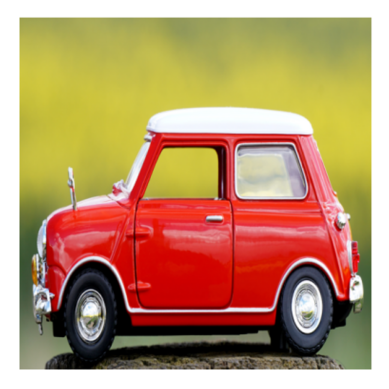

In [6]:
# load image in example/car.jpg and plot it

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

image_path = "Voiture_Genia.png"
image = Image.open(image_path).convert("RGB")
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
image = image.to(diffusion_model.device)

# Etape 1 : Find eopt


In [7]:
prompt = "A yellow car"
device = "cuda"

timesteps = 1
alpha_t = 0.5

In [8]:
# This function is the first step (A) Optimize embedding and find eopt
def optimize_embeddings(input_image, target_text, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=1000):

  tokens = tokenizer(target_text, padding="max_length", truncation=True, return_tensors="pt")
  prompt_tokens = tokens.input_ids.to(device)


  # freeze embedding model parameters
  with torch.no_grad():
      etgt = text_encoder(prompt_tokens).last_hidden_state


  # Ici on initialise eopt (l'embedding a optimiser)
  eopt = etgt.clone().detach().requires_grad_(True)

  optimizer = optim.Adam([eopt], lr=2e-3)
  criterion = nn.MSELoss()


  # freeze diffusion model parameters
  for param in diffusion_model.parameters():
      param.requires_grad = False

  image = input_image.clone()

  # Permet de normaliser l'image (peut-être pas nécessaire)
  image_m1_1 = (image.to(device) * 2.0) - 1.0

  with torch.no_grad():
      image_latent = vae.encode(image_m1_1).latent_dist
      image_latent = image_latent.mean * vae.config.scaling_factor
      image_latent.to(device)


  for i in range(nb_step):
      print("step " , i)
      noise_latent = torch.randn_like(image_latent)

      t = torch.randint(1, 50, size=(1,)).to(device)

      # Le scheduler permet d'ajouter du bruit t
      image_latent_noise = scheduler.add_noise(image_latent, noise_latent, t)

      # .sample permet de récupérer spécifiquement le tensor
      output = diffusion_model(image_latent_noise, t, encoder_hidden_states=eopt)
      noise_pred = output.sample

      noise_latent = scheduler.scale_model_input(noise_latent, t)

      # update embeddings
      optimizer.zero_grad()
      loss = criterion(noise_pred, noise_latent)
      loss.backward()
      optimizer.step()

  return (etgt, eopt)


etgt, eopt = optimize_embeddings(image, prompt, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=100)



step  0
step  1
step  2
step  3
step  4
step  5
step  6
step  7
step  8
step  9
step  10
step  11
step  12
step  13
step  14
step  15
step  16
step  17
step  18
step  19
step  20
step  21
step  22
step  23
step  24
step  25
step  26
step  27
step  28
step  29
step  30
step  31
step  32
step  33
step  34
step  35
step  36
step  37
step  38
step  39
step  40
step  41
step  42
step  43
step  44
step  45
step  46
step  47
step  48
step  49
step  50
step  51
step  52
step  53
step  54
step  55
step  56
step  57
step  58
step  59
step  60
step  61
step  62
step  63
step  64
step  65
step  66
step  67
step  68
step  69
step  70
step  71
step  72
step  73
step  74
step  75
step  76
step  77
step  78
step  79
step  80
step  81
step  82
step  83
step  84
step  85
step  86
step  87
step  88
step  89
step  90
step  91
step  92
step  93
step  94
step  95
step  96
step  97
step  98
step  99


In [9]:
print(etgt)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.9568, -0.3391, -0.3438,  ...,  1.6478, -0.9793,  0.8329],
         ...,
         [ 0.8534, -0.2147, -0.9066,  ...,  0.0736,  0.3958, -0.4212],
         [ 0.8670, -0.2368, -0.8705,  ...,  0.0706,  0.3949, -0.3897],
         [ 0.8155, -0.1587, -0.8455,  ...,  0.0757,  0.4136, -0.4125]]],
       device='cuda:0')


In [10]:
print(eopt)

tensor([[[-0.4810,  0.0314, -0.0332,  ..., -0.3880, -0.4460,  0.0684],
         [ 0.0585, -1.4220,  0.3875,  ..., -0.3754,  1.1312,  0.7119],
         [ 0.9860, -0.3901, -0.2565,  ...,  1.6231, -1.0143,  0.8443],
         ...,
         [ 0.7871, -0.1366, -0.8723,  ...,  0.1299,  0.3885, -0.4525],
         [ 0.8021, -0.1612, -0.8374,  ...,  0.1265,  0.3863, -0.4194],
         [ 0.7476, -0.0821, -0.8138,  ...,  0.1317,  0.4041, -0.4482]]],
       device='cuda:0', requires_grad=True)


# Etape 2

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


def finetune_unet(
    input_image_0_1, # Image originale (tenseur 0-1)
    eopt,            
    unet,
    vae,             # Le VAE (pour encoder l'image)
    scheduler,       # Le scheduler (pour bruiter)
    device,
    num_steps=1500,
    lr=5e-7
):

    unet.train() # Met le modèle en mode entraînement
    for param in unet.parameters():
        param.requires_grad = True # S'assurer que les gradients sont activés


    # Optimizer pour Unet
    optimizer = optim.AdamW(unet.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Même chose que pour eopt
    image_m1_1 = (input_image_0_1.to(device) * 2.0) - 1.0

    # Pas besoin de modifier vae
    with torch.no_grad():
        encoded_dist = vae.encode(image_m1_1).latent_dist
        z0 = encoded_dist.mean * vae.config.scaling_factor
        
        
    # --- Boucle de Fine-tuning ---
    progress_bar = tqdm.tqdm(range(num_steps))
    for step in range(num_steps):
        print("step = ", step)
        optimizer.zero_grad()

        noise_latent = torch.randn_like(z0, device=device)
        t = torch.randint(1, 50, size=(1,)).to(device)

        zt = scheduler.add_noise(z0, noise_latent, t)
        output = unet(zt, t, encoder_hidden_states=eopt)
        noise_pred = output.sample

        # Calculate loss
        loss = criterion(noise_pred, noise_latent)

        # Backpropagate
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
        progress_bar.set_postfix({"Loss": loss.item()})

    return unet




unet_fine_tuned = finetune_unet(
    image,
    eopt, # L'output de optimize_embeddings
    diffusion_model,
    vae,
    scheduler,
    device,
    num_steps=150,
    lr=5e-7
)


  0%|          | 0/150 [00:00<?, ?it/s]

step =  0


  1%|          | 1/150 [00:37<06:05,  2.45s/it, Loss=0.631]

step =  1


  1%|▏         | 2/150 [02:39<1:33:50, 38.04s/it, Loss=0.509]

step =  2


  2%|▏         | 3/150 [04:16<3:07:59, 76.73s/it, Loss=0.465]

step =  3


  3%|▎         | 4/150 [06:09<3:28:36, 85.73s/it, Loss=0.34] 

step =  4


  3%|▎         | 5/150 [08:01<3:50:24, 95.34s/it, Loss=0.48]

step =  5


  4%|▍         | 6/150 [09:59<3:56:51, 98.69s/it, Loss=0.474]

step =  6


  5%|▍         | 7/150 [11:56<4:16:53, 107.78s/it, Loss=0.56] 

step =  7


  5%|▌         | 8/150 [13:41<4:16:44, 108.48s/it, Loss=0.564]

step =  8


  6%|▌         | 9/150 [15:34<4:17:44, 109.68s/it, Loss=0.413]

step =  9


  7%|▋         | 10/150 [17:27<4:13:31, 108.65s/it, Loss=0.547]

step =  10


  7%|▋         | 11/150 [19:14<4:13:41, 109.51s/it, Loss=0.31] 

step =  11


  8%|▊         | 12/150 [20:51<4:06:59, 107.39s/it, Loss=0.452]

step =  12


  9%|▊         | 13/150 [22:34<4:01:27, 105.75s/it, Loss=0.306]

step =  13


  9%|▉         | 14/150 [24:18<4:01:17, 106.45s/it, Loss=0.364]

step =  14


 10%|█         | 15/150 [25:57<3:54:34, 104.26s/it, Loss=0.392]

step =  15


 11%|█         | 16/150 [27:44<3:50:50, 103.36s/it, Loss=0.303]

step =  16


 11%|█▏        | 17/150 [29:17<3:50:09, 103.83s/it, Loss=0.327]

step =  17


 12%|█▏        | 18/150 [30:53<3:38:17, 99.23s/it, Loss=0.327] 

step =  18


 13%|█▎        | 19/150 [32:38<3:40:36, 101.04s/it, Loss=0.529]

step =  19


 13%|█▎        | 20/150 [34:14<3:36:31, 99.94s/it, Loss=0.379] 

step =  20


 14%|█▍        | 21/150 [35:54<3:32:07, 98.66s/it, Loss=0.307]

step =  21


 15%|█▍        | 22/150 [37:32<3:29:00, 97.97s/it, Loss=0.294]

step =  22


 15%|█▌        | 23/150 [39:06<3:27:11, 97.89s/it, Loss=0.468]

step =  23


 16%|█▌        | 24/150 [40:44<3:24:54, 97.57s/it, Loss=0.42] 

step =  24


 17%|█▋        | 25/150 [42:27<3:22:26, 97.17s/it, Loss=0.732]

step =  25


 17%|█▋        | 26/150 [43:58<3:23:38, 98.53s/it, Loss=0.306]

step =  26


 18%|█▊        | 27/150 [45:59<3:25:51, 100.42s/it, Loss=0.337]

step =  27


 19%|█▊        | 28/150 [47:49<3:33:09, 104.83s/it, Loss=0.351]

step =  28


 19%|█▉        | 29/150 [49:31<3:30:43, 104.49s/it, Loss=0.325]

step =  29


 20%|██        | 30/150 [51:07<3:26:25, 103.21s/it, Loss=0.346]

step =  30


 21%|██        | 31/150 [52:38<3:20:58, 101.33s/it, Loss=0.403]

step =  31


 21%|██▏       | 32/150 [54:11<3:14:13, 98.76s/it, Loss=0.332] 

step =  32


 22%|██▏       | 33/150 [56:03<3:16:52, 100.96s/it, Loss=0.36] 

step =  33


 23%|██▎       | 34/150 [57:38<3:15:27, 101.10s/it, Loss=0.556]

step =  34


 23%|██▎       | 35/150 [59:24<3:06:58, 97.55s/it, Loss=0.455] 

step =  35


 24%|██▍       | 36/150 [1:00:59<3:14:06, 102.16s/it, Loss=0.299]

step =  36


 25%|██▍       | 37/150 [1:02:43<3:08:26, 100.06s/it, Loss=0.307]

step =  37


 25%|██▌       | 38/150 [1:04:15<3:03:39, 98.38s/it, Loss=0.294] 

step =  38


 26%|██▌       | 39/150 [1:05:52<2:58:35, 96.53s/it, Loss=0.36] 

step =  39


 27%|██▋       | 40/150 [1:07:36<3:01:30, 99.01s/it, Loss=0.326]

step =  40


 27%|██▋       | 41/150 [1:09:16<3:03:50, 101.20s/it, Loss=0.304]

step =  41


 28%|██▊       | 42/150 [1:11:13<3:04:09, 102.31s/it, Loss=0.291]

step =  42


 29%|██▊       | 43/150 [1:13:08<3:06:59, 104.86s/it, Loss=0.354]

step =  43


 29%|██▉       | 44/150 [1:15:00<3:14:08, 109.89s/it, Loss=0.427]

step =  44


 30%|███       | 45/150 [1:17:00<3:12:30, 110.00s/it, Loss=0.631]

step =  45


 31%|███       | 46/150 [1:18:56<3:15:03, 112.54s/it, Loss=0.393]

step =  46


 31%|███▏      | 47/150 [1:20:43<3:16:58, 114.74s/it, Loss=0.599]

step =  47


 32%|███▏      | 48/150 [1:22:57<3:10:34, 112.11s/it, Loss=0.535]

step =  48


 33%|███▎      | 49/150 [1:24:56<3:20:03, 118.85s/it, Loss=0.344]

step =  49


 33%|███▎      | 50/150 [1:26:36<3:13:17, 115.98s/it, Loss=0.365]

step =  50


 34%|███▍      | 51/150 [1:28:23<3:09:14, 114.69s/it, Loss=0.664]

step =  51


 35%|███▍      | 52/150 [1:30:14<3:00:01, 110.22s/it, Loss=0.335]

step =  52


 35%|███▌      | 53/150 [1:32:20<3:01:07, 112.03s/it, Loss=0.445]

step =  53


 36%|███▌      | 54/150 [1:34:29<3:08:23, 117.75s/it, Loss=0.279]

step =  54


 37%|███▋      | 55/150 [1:36:20<3:09:38, 119.78s/it, Loss=0.38] 

step =  55


 37%|███▋      | 56/150 [1:38:18<3:02:22, 116.41s/it, Loss=0.444]

step =  56


 38%|███▊      | 57/150 [1:40:06<2:58:27, 115.13s/it, Loss=0.319]

step =  57


 39%|███▊      | 58/150 [1:42:06<2:58:06, 116.15s/it, Loss=0.299]

step =  58


 39%|███▉      | 59/150 [1:43:58<2:53:38, 114.49s/it, Loss=0.557]

step =  59


 40%|████      | 60/150 [1:45:56<2:52:51, 115.24s/it, Loss=0.295]

step =  60


 41%|████      | 61/150 [1:47:51<2:53:14, 116.79s/it, Loss=0.421]

step =  61


 41%|████▏     | 62/150 [1:49:51<2:50:09, 116.01s/it, Loss=0.289]

step =  62


 42%|████▏     | 63/150 [1:51:53<2:48:44, 116.37s/it, Loss=0.293]

step =  63


 43%|████▎     | 64/150 [1:53:45<2:49:55, 118.56s/it, Loss=0.325]

step =  64


 43%|████▎     | 65/150 [1:55:44<2:44:48, 116.33s/it, Loss=0.334]

step =  65


 44%|████▍     | 66/150 [1:57:42<2:46:02, 118.60s/it, Loss=0.454]

step =  66


 45%|████▍     | 67/150 [1:59:40<2:41:44, 116.92s/it, Loss=0.546]

step =  67


 45%|████▌     | 68/150 [2:01:37<2:39:51, 116.97s/it, Loss=0.337]

step =  68


 46%|████▌     | 69/150 [2:03:38<2:39:23, 118.07s/it, Loss=0.298]

step =  69


 47%|████▋     | 70/150 [2:05:36<2:38:13, 118.67s/it, Loss=0.357]

step =  70


 47%|████▋     | 71/150 [2:07:19<2:32:40, 115.95s/it, Loss=0.284]

step =  71


 48%|████▊     | 72/150 [2:09:21<2:29:24, 114.93s/it, Loss=0.664]

step =  72


 49%|████▊     | 73/150 [2:11:18<2:29:42, 116.65s/it, Loss=0.342]

step =  73


 49%|████▉     | 74/150 [2:13:16<2:27:00, 116.06s/it, Loss=0.484]

step =  74


 50%|█████     | 75/150 [2:15:20<2:27:20, 117.87s/it, Loss=0.489]

step =  75


 51%|█████     | 76/150 [2:16:59<2:26:27, 118.76s/it, Loss=0.63] 

step =  76


 51%|█████▏    | 77/150 [2:18:47<2:16:37, 112.30s/it, Loss=0.36]

step =  77


 52%|█████▏    | 78/150 [2:20:32<2:12:03, 110.04s/it, Loss=0.473]

step =  78


 53%|█████▎    | 79/150 [2:22:33<2:10:41, 110.44s/it, Loss=0.376]

step =  79


 53%|█████▎    | 80/150 [2:24:26<2:10:54, 112.21s/it, Loss=0.426]

step =  80


 54%|█████▍    | 81/150 [2:26:21<2:10:34, 113.54s/it, Loss=0.432]

step =  81


 55%|█████▍    | 82/150 [2:28:14<2:10:01, 114.73s/it, Loss=0.392]

step =  82


 55%|█████▌    | 83/150 [2:30:05<2:04:36, 111.60s/it, Loss=0.359]

step =  83


 56%|█████▌    | 84/150 [2:32:07<2:07:06, 115.55s/it, Loss=0.345]

step =  84


 57%|█████▋    | 85/150 [2:34:12<2:04:27, 114.88s/it, Loss=0.332]

step =  85


 57%|█████▋    | 86/150 [2:36:04<2:04:18, 116.53s/it, Loss=0.529]

step =  86


 58%|█████▊    | 87/150 [2:37:58<2:02:50, 116.99s/it, Loss=0.617]

step =  87


 59%|█████▊    | 88/150 [2:39:56<1:59:09, 115.32s/it, Loss=0.418]

step =  88


 59%|█████▉    | 89/150 [2:41:50<1:57:57, 116.03s/it, Loss=0.672]

step =  89


 60%|██████    | 90/150 [2:43:44<1:56:17, 116.29s/it, Loss=0.311]

step =  90


 61%|██████    | 91/150 [2:45:41<1:54:56, 116.89s/it, Loss=0.37] 

step =  91


 61%|██████▏   | 92/150 [2:47:33<1:50:57, 114.79s/it, Loss=0.352]

step =  92


 62%|██████▏   | 93/150 [2:49:32<1:49:15, 115.01s/it, Loss=0.282]

step =  93


 63%|██████▎   | 94/150 [2:51:32<1:48:28, 116.22s/it, Loss=0.335]

step =  94


 63%|██████▎   | 95/150 [2:53:31<1:48:02, 117.87s/it, Loss=0.281]

step =  95


 64%|██████▍   | 96/150 [2:55:30<1:45:23, 117.10s/it, Loss=0.324]

step =  96


 65%|██████▍   | 97/150 [2:57:24<1:44:22, 118.15s/it, Loss=0.355]

step =  97


 65%|██████▌   | 98/150 [2:59:14<1:40:36, 116.09s/it, Loss=0.373]

step =  98


 66%|██████▌   | 99/150 [3:01:07<1:36:33, 113.60s/it, Loss=0.504]

step =  99


 67%|██████▋   | 100/150 [3:03:12<1:36:25, 115.71s/it, Loss=0.326]

step =  100


 67%|██████▋   | 101/150 [3:05:13<1:36:43, 118.43s/it, Loss=0.315]

step =  101


 68%|██████▊   | 102/150 [3:07:21<1:33:55, 117.41s/it, Loss=0.287]

step =  102


 69%|██████▊   | 103/150 [3:09:41<1:36:13, 122.84s/it, Loss=0.367]

step =  103


 69%|██████▉   | 104/150 [3:12:13<1:38:42, 128.74s/it, Loss=0.286]

step =  104


 70%|███████   | 105/150 [3:14:44<1:42:06, 136.14s/it, Loss=0.323]

step =  105


 71%|███████   | 106/150 [3:17:24<1:44:31, 142.53s/it, Loss=0.428]

step =  106


 71%|███████▏  | 107/150 [3:19:47<1:45:17, 146.91s/it, Loss=0.651]

step =  107


 72%|███████▏  | 108/150 [3:22:20<1:40:23, 143.42s/it, Loss=0.301]

step =  108


 73%|███████▎  | 109/150 [3:24:57<1:41:44, 148.89s/it, Loss=0.652]

step =  109


 73%|███████▎  | 110/150 [3:27:23<1:39:27, 149.18s/it, Loss=0.469]

step =  110


 74%|███████▍  | 111/150 [3:29:59<1:37:05, 149.38s/it, Loss=0.327]

step =  111


 75%|███████▍  | 112/150 [3:32:54<1:37:07, 153.34s/it, Loss=0.3]  

step =  112


 75%|███████▌  | 113/150 [3:35:29<1:35:43, 155.24s/it, Loss=0.387]

step =  113


 76%|███████▌  | 114/150 [3:37:55<1:33:47, 156.31s/it, Loss=0.301]

step =  114


 77%|███████▋  | 115/150 [3:40:18<1:30:18, 154.81s/it, Loss=0.35] 

step =  115


 77%|███████▋  | 116/150 [3:43:02<1:26:10, 152.06s/it, Loss=0.323]

step =  116


 78%|███████▊  | 117/150 [3:45:38<1:24:52, 154.33s/it, Loss=0.4]  

step =  117


 79%|███████▊  | 118/150 [3:48:13<1:22:37, 154.92s/it, Loss=0.276]

step =  118


 79%|███████▉  | 119/150 [3:50:34<1:20:13, 155.27s/it, Loss=0.319]

step =  119


 80%|████████  | 120/150 [3:53:06<1:14:35, 149.18s/it, Loss=0.311]

step =  120


 81%|████████  | 121/150 [3:55:38<1:13:59, 153.09s/it, Loss=0.346]

step =  121


 81%|████████▏ | 122/150 [3:58:21<1:10:50, 151.81s/it, Loss=0.425]

step =  122


 82%|████████▏ | 123/150 [4:00:48<1:09:25, 154.29s/it, Loss=0.473]

step =  123


 83%|████████▎ | 124/150 [4:03:23<1:06:04, 152.48s/it, Loss=0.382]

step =  124


 83%|████████▎ | 125/150 [4:05:52<1:03:40, 152.81s/it, Loss=0.295]

step =  125


 84%|████████▍ | 126/150 [4:08:31<1:00:58, 152.45s/it, Loss=0.375]

step =  126


 85%|████████▍ | 127/150 [4:10:57<59:06, 154.18s/it, Loss=0.343]  

step =  127


 85%|████████▌ | 128/150 [4:13:40<55:56, 152.55s/it, Loss=0.392]

step =  128


 86%|████████▌ | 129/150 [4:16:18<54:07, 154.64s/it, Loss=0.314]

step =  129


 87%|████████▋ | 130/150 [4:18:45<52:50, 158.52s/it, Loss=0.624]

step =  130


 87%|████████▋ | 131/150 [4:21:21<48:14, 152.35s/it, Loss=0.275]

step =  131


 88%|████████▊ | 132/150 [4:23:41<45:15, 150.86s/it, Loss=0.294]

step =  132


 89%|████████▊ | 133/150 [4:25:52<42:07, 148.65s/it, Loss=0.479]

step =  133


 89%|████████▉ | 134/150 [4:27:10<38:28, 144.29s/it, Loss=0.397]

step =  134


 90%|█████████ | 135/150 [4:29:27<30:18, 121.20s/it, Loss=0.419]

step =  135


 91%|█████████ | 136/150 [4:31:41<29:33, 126.67s/it, Loss=0.361]

step =  136


 91%|█████████▏| 137/150 [4:33:54<28:14, 130.38s/it, Loss=0.306]

step =  137


 92%|█████████▏| 138/150 [4:36:05<26:08, 130.68s/it, Loss=0.398]

step =  138


 93%|█████████▎| 139/150 [4:38:17<24:05, 131.38s/it, Loss=0.544]

step =  139


 93%|█████████▎| 140/150 [4:40:25<21:37, 129.73s/it, Loss=0.276]

step =  140


 94%|█████████▍| 141/150 [4:42:35<19:38, 130.95s/it, Loss=0.291]

step =  141


 95%|█████████▍| 142/150 [4:44:46<17:14, 129.33s/it, Loss=0.344]

step =  142


 95%|█████████▌| 143/150 [4:46:55<15:18, 131.19s/it, Loss=0.301]

step =  143


 96%|█████████▌| 144/150 [4:49:25<13:18, 133.17s/it, Loss=0.518]

step =  144


 97%|█████████▋| 145/150 [4:51:50<11:27, 137.50s/it, Loss=0.298]

step =  145


 97%|█████████▋| 146/150 [4:54:14<09:11, 137.93s/it, Loss=0.376]

step =  146


 98%|█████████▊| 147/150 [4:56:37<07:01, 140.67s/it, Loss=0.272]

step =  147


 99%|█████████▊| 148/150 [4:59:00<04:42, 141.08s/it, Loss=0.281]

step =  148


 99%|█████████▉| 149/150 [5:01:16<02:22, 142.67s/it, Loss=0.519]

step =  149


100%|██████████| 150/150 [5:03:45<00:00, 121.51s/it, Loss=0.316]


# Etape 3

In [12]:

def interpolate_embeddings(etgt, eopt, eta):


  # Interpolation linéaire simple
  e_interpolated = eta * etgt + (1 - eta) * eopt

  print(f"Interpolation avec eta={eta:.2f}")
  print(f"Shape de etgt: {etgt.shape}, Device: {etgt.device}")
  print(f"Shape de eopt: {eopt.shape}, Device: {eopt.device}")
  print(f"Shape de e_interpolated: {e_interpolated.shape}, Device: {e_interpolated.device}")

  return e_interpolated

interpolation_factor_eta = 0.7
e_interpolated = interpolate_embeddings(etgt, eopt, eta=interpolation_factor_eta)


Interpolation avec eta=0.70
Shape de etgt: torch.Size([1, 77, 768]), Device: cuda:0
Shape de eopt: torch.Size([1, 77, 768]), Device: cuda:0
Shape de e_interpolated: torch.Size([1, 77, 768]), Device: cuda:0


# Script permettant d'observer la prédiction du modèle avec etbt après optimisation  

##  (A utiliser uniquement pour le rapport)

Starting denoising loop...


  0%|          | 0/51 [00:00<?, ?it/s]

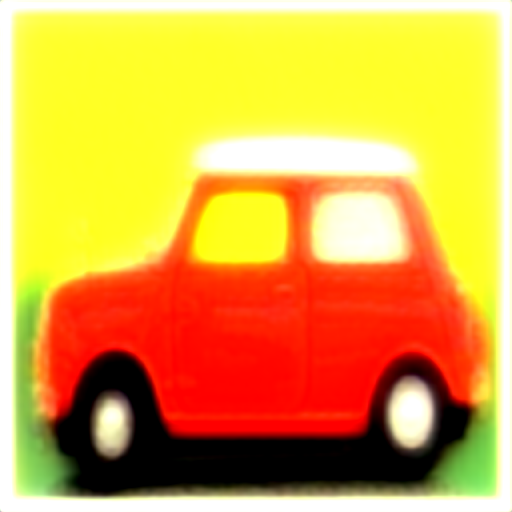

In [13]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(input_image, eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, seed=None):

    image_m1_1 = (input_image * 2.0) - 1.0

    with torch.no_grad():
        image_latent = vae.encode(image_m1_1).latent_dist
        latents = image_latent.mean * vae.config.scaling_factor
        latents.to(device)


    # 3. Définir les timesteps
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)


    # Boucle pour enlever le bruit
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        latent_model_input = scheduler.scale_model_input(latents, t) # Mise à l'échelle si besoin

        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    # Passer de l'espace latent à l'image réelle
    latents = latents / vae.config.scaling_factor
    image_pixels = vae.decode(latents).sample

    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # Remap [-1, 1] -> [0, 1]
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # Format [Batch, H, W, C] pour PIL
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # Prend la 1ere image du batch

    return image_pil


generate_with_eopt(image, eopt, diffusion_model, scheduler, vae, device="cuda", height=512, width=512, num_inference_steps=50, guidance_scale=7.5, seed=None)

Starting denoising loop...


  0%|          | 0/51 [00:00<?, ?it/s]

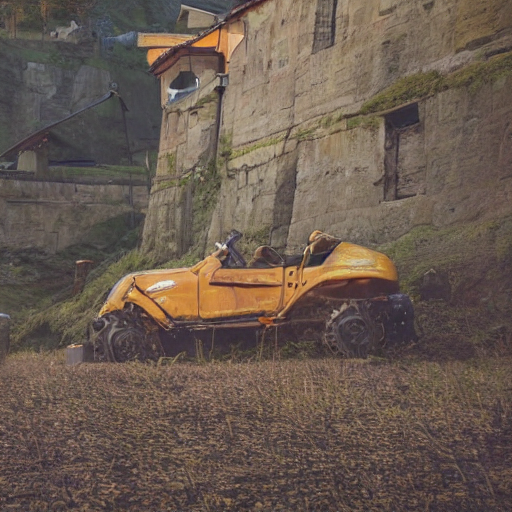

In [18]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(input_image, eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50):

    image_m1_1 = (input_image * 2.0) - 1.0

    with torch.no_grad():
        image_latent = vae.encode(image_m1_1).latent_dist
        latents = image_latent.mean * vae.config.scaling_factor
        latents.to(device)

    # Génération a partir de bruit
    latents = torch.randn_like(latents)

    # 3. Définir les timesteps
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)


    # Boucle pour enlever le bruit
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        latent_model_input = scheduler.scale_model_input(latents, t) # Mise à l'échelle si besoin

        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    # Passer de l'espace latent à l'image réelle
    latents = latents / vae.config.scaling_factor
    image_pixels = vae.decode(latents).sample

    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # Remap [-1, 1] -> [0, 1]
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # Format [Batch, H, W, C] pour PIL
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # Prend la 1ere image du batch

    return image_pil

#je mets e_interpolated au lieu de eopt
generate_with_eopt(image, eopt, unet_fine_tuned, scheduler, vae, device="cuda", height=512, width=512, num_inference_steps=50)

# Test


In [14]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, seed=None): # Removed input_image from args
    """Génère une image en utilisant l'embedding optimisé eopt, en partant de bruit."""

    # --- Initial Setup ---
    if seed is not None:
        generator = torch.Generator(device=device).manual_seed(seed)
    else:
        generator = None

    unet = unet.to(device).eval()
    vae = vae.to(device).eval()
    eopt = eopt.to(device)

    # --- 1. Initialisation du Bruit Latent ---
    # PAS d'encodage de l'image d'entrée ici.
    # image_m1_1 = (input_image * 2.0) - 1.0 # ERREUR : Supprimé
    # with torch.no_grad(): # ERREUR : Supprimé
    #     image_latent = vae.encode(image_m1_1).latent_dist # ERREUR : Supprimé
    #     latents = image_latent.mean * vae.config.scaling_factor # ERREUR : Supprimé
    #     latents.to(device) # ERREUR : Supprimé

    # CORRECTION : Créer bruit aléatoire
    latent_height = height // 8
    latent_width = width // 8
    latent_channels = unet.config.in_channels
    latent_shape = (1, latent_channels, latent_height, latent_width)
    latents = torch.randn(latent_shape, generator=generator, device=device, dtype=unet.dtype)
    print(f"Initial random latents shape: {latents.shape}, Device: {latents.device}")


    # --- 2. Préparer le Scheduler ---
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device) # OK

    # Mise à l'échelle initiale du bruit (important !)
    latents = latents * scheduler.init_noise_sigma # OK


    # --- ERREUR : Ligne ajoutée incorrecte ---
    # noise_latent = torch.randn_like(latents) # ERREUR : Bruit redondant
    # latents = diffusion_model(noise_latent, timesteps, encoder_hidden_states=eopt).to(device) # ERREUR : Conceptuellement faux
    # Cette ligne essayait d'appeler le modèle sur du bruit pur avec *tous* les timesteps en même temps ?
    # Elle court-circuitait complètement la boucle de débruitage itératif. Supprimée.


    # --- 3. Boucle de Débruitage ---
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        # Pas de guidance nécessaire ici
        latent_model_input = scheduler.scale_model_input(latents, t) # OK (Mise à l'échelle si besoin)

        # Prédire le bruit avec le UNet
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample # OK

        # Calculer l'état précédent avec le scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample # OK
    print("Denoising finished.")


    # --- 4. Décoder l'Image Latente Finale ---
    latents = latents / vae.config.scaling_factor # OK
    print("Decoding final latents...")
    image_pixels = vae.decode(latents).sample # OK

    # --- 5. Post-traitement ---
    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # OK
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # OK
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # OK

    return image_pil


# --- Appel ---
# Assurez-vous que 'eopt' est l'embedding optimisé et DÉTACHÉ
# Assurez-vous que 'unet' (diffusion_model dans l'appel original), 'scheduler', 'vae' sont chargés
# Assurez-vous que 'device' est défini

# image_result = generate_with_eopt(eopt, unet, scheduler, vae, device, num_inference_steps=50, seed=42)
# image_result.show()

# Example generation Text-Image



In [15]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "An astronaut riding horse in Mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 